In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from CustomerReviews import Reviews
import warnings
warnings.filterwarnings("ignore")
from imp import reload

C:\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


>用户体验的工作可以说是用户需求和用户认知的分析。而消费者的声音是其中很重要的一环，它包含了用户对产品的评论，不管是好的坏的，都将对我们产品的改进和迭代有帮助。另外任何事情都要考虑金钱成本和人力成本，因此我希望能通过机器学习的算法来辅助分析，对用户的评论数据进行提炼和洞察。



## 一、数据获取和清洗

现在爬虫泛滥，网络公开数据的获取并不再是一个难题。简单点可以利用一些互联网的爬虫服务（如神箭手、八爪鱼等），复杂点也可以自己写爬虫。这里我们用爬虫来获取京东的评论数据。相对于亚马逊而言，京东比较坑。第一个坑是京东的反爬虫还不错，通过正常产品网址进去的那个评论列表是几乎爬不出数据来的，所有大部分网络爬虫服务都止步于此。第二个坑是一款产品的评论数只要超过**一万条**，那么京东就只会显示前**一千条**，没有公开的数据，那你爬虫技术再厉害也没办法，除非开着爬虫定时增量更新数据。

自己写爬虫的好处就是可以避免掉进第一个坑，但是第二个坑没办法。这里我爬取了 `小米MIX` 和 `小米MIX2` 的评论数据(最新的几款手机我都爬取了，需要的请戳后台)，其中 `小米MIX` 共1578条，`小米MIX2` 共3292条。

本文通过分析这些数据预期完成如下几个目标

- 1、数据清洗后的好评率
- 2、好/中/差评的概览
- 3、典型意见分析

首先来看看MIX2的大致情况：

In [7]:
data=pd.read_csv('.\\data\\小米MIX2.csv')
# 爬取的数据包含的字段
print('包含字段:\n'+'||'.join(data.columns))
# 将评论创建的时间转化为时间格式
data['creationTime']=pd.to_datetime(data['creationTime'])
# days 是从购买到首次评论的天数，score是用户的评分，1-5分
data[['days','score']].describe()

包含字段:
pid||guid||creationTime||days||content||nickname||productColor||referenceId||referenceName||referenceTime||score||userClient||userLevelId||userLevelName||userProvince||userRegisterTime||版本||购买方式


,days,score
count,3497.000000,3497.000000
mean,9.056048,4.877323
std,11.497973,0.581064
min,0.000000,1.000000
25%,1.000000,5.000000
50%,4.000000,5.000000
75%,10.000000,5.000000
max,42.000000,5.000000


In [8]:
data[['content','productColor']].describe()

,content,productColor
count,3497,3497
unique,3309,1
top,很好,黑
freq,24,3497


一共有3497条评论，其中有些评论内容还是完全相同的。用户大概在购买9天后后评论（可能与到货日期有关），平均打分为4.87分，评论里面有些完全相同的，小米MIX2只有一种颜色等等。

接下来我们先做第一件事情

In [9]:
comments=Reviews(texts=data['content'],scores=data['score'],creationTime=data['creationTime'])
comments.describe()
# 这里的 `Reviews` 是作者自己造的轮子，封装了很多NLP的算法，便于评论语料的分析。

样本数              3292
平均字符数            38.5
好评       3181(96.63%)
中评          61(1.85%)
差评          50(1.52%)
dtype: object

京东采用的是5分制，其中4-5分为好评，2-4分为中评，1分为差评。MIX2的好评率为96.63%，与京东官网的一致。

粗略的浏览以下评论，我们发现有这么几种无效评论。

第一种全是标点符号或者就一两个字：

![]('垃圾评论1.png')

这种情况可以利用正则表达式来去除，第二种比较麻烦，如：

![]('垃圾评论2.png')

这种评论中它纯属凑字数和灌水，不含任何产品的特征。一种想法是看看评论中涉及的名词是否是手机领域中的词语，但是实际情况会非常复杂，比如

“用的很不错”、“太差了”...

这里我们反过来，假设每一类无效评论都有类似的关键词，一个评论中的词语只要有一些垃圾评论关键词，我们就把它判定为无效评论。当然并也不需要给定所有的无效评论词，利用tfidf可以通过一个词语顺藤摸瓜找到其他类似的词语。（还可以利用文本相似性算法寻找）


In [11]:
warnings.filterwarnings("ignore")
# 解决一词多义问题以及统一产品特征名词。比如触摸屏-->触屏,samsung-->三星等
comments.replace('synonyms.txt')
# 分词。此处用的是结巴分词工具，添加了手机领域的专有词、以及产品特点词语，比如磨砂黑、玫瑰金等
comments.segment(product_dict='mobile_dict.txt',stopwords='.\\stopwords\\chinese.txt',add_words=['磨砂黑','玫瑰金'])
# 去除无效评论
initial_words=['京东豆','数数','经济','杂交','今生今世','红红火火','彰显','荣华富贵','仰慕','滔滔不绝','永不变心','海枯石烂','天崩地裂']
comments.drop_invalid(initial_words=initial_words,max_rate=0.6)
comments.describe()

样本数              3175
平均字符数            39.3
好评       3065(96.54%)
中评          60(1.89%)
差评          50(1.57%)
dtype: object

另外还有一种情况，虽然不属于无效评论，但是影响好评占比

![](评分修正.png)

这种情况在追评中出现的较多，还有就是京东默认的好评。虽然内容是差评，但是标记的分值是5分。理论上也可以通过算法找出大部分。在NLP领域中，有一个课题叫做情感分析（sentiment analysis）, 它可以判断一句话的情感方向是正面的还是负面的（以概率大小给出，数值在0-1之间）。如果一段评论的情感方向与对应的评分差异过大，则我们有理由相信它的评分是有误的。当然这里有一个条件，那就是这个情感分析算法是非常准确的。

有大神专门用电商评论训练了一个开源的情感分析包snownlp, 我们来看看这个包效果怎样。

acc = 92.63%, AUC = 0.157


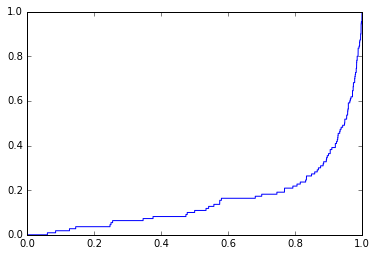

In [8]:
from sklearn import metrics
ss=comments.sentiments(method='snownlp')
# 此处是典型的样本不平衡问题，所以预测概率需要 “再缩放”
acc=metrics.accuracy_score(comments.scores,pd.cut(ss,[-0.1,0.0158,0.0347,1],labels=['差评','中评','好评']))
fpr, tpr, thresholds = metrics.roc_curve(comments.scores.replace({'好评':-1,'中评':1,'差评':1}), ss)
auc=metrics.roc_auc_score(comments.scores.replace({'好评':-1,'中评':1,'差评':1}), ss)
print('acc = {:.2f}%, AUC = {:.3f}'.format(acc*100,auc))
plt.plot(fpr,tpr)

嗯嗯，准确率为92.63%，看上去很高，但。。。因为我把所有评论都判定为好评，那正确率也有96.54%。再看上图中的ROC曲线，嗯，惨不忍睹。曲线跟x轴之间的面积（记作AUC）越大，说明模型的判别能力越好。一般情况曲线会在对角线之上（对角线相当于随机预测的结果），可以此时AUC=0.157，比随机结果差多啦。

更好的情感分析估计需要利用大量手机领域的语料重新训练才行，本文就暂不讨论这个啦。


## 二、好/中/差评的语义理解


语义理解是一个非常难的课题，本文不追求绝对精准，仅希望能对产品的评论有一个快速的理解。本文将从三个方面来阐述同类型评论语料的语义：

- 1、**词云**。它会统计一段文本中各个词语出现的次数（频数），频数越大，在词云中对应的字体也越大。通过观察词云，可以知道一段文本主要在讲哪些东西

- 2、**TextRank**。 TextRank 算法是一种用于文本的基于图的排序算法，可以给出一段文本的关键词。其基本思想来源于谷歌的PageRank算法, 通过把文本分割成若干组成单元(单词、句子)并建立图模型, 利用投票机制对文本中的重要成分进行排序, 仅利用单篇文档本身的信息即可实现关键词提取、文摘。和 LDA、HMM 等模型不同, TextRank不需要事先对多篇文档进行学习训练, 因其简洁有效而得到广泛应用。

- 3、**主题分解**。 假设每一段文本都是有主题的，比如新闻里的体育类、时事类、八卦类等。通过对一系列的语料库进行主题分解（本文采用的是LDA），可以了解语料库涉及了哪些主题。（本文用的LDA实际效果不怎么好，暂且仅供娱乐。更好的方法后续或许会更新）

好评 的关键词为：手机|小米|京东|没有|屏幕|感觉|手感|速度|有点|系统|喜欢|支持|全面屏|满意|问题|使用|边框|抢到|拍照|摄像头
主题 0: 用 | 不错 | 买 | 小米 | 手机 | 东西 | 京东 | 感觉 | 挺 | 评价
主题 1: 不错 | 手机 | 用 | 小米 | 很好 | 手感 | 屏幕 | 高 | 喜欢 | 全面屏
主题 2: 黑 | 手机 | 满意 | 宽 | 不错 | 屏幕 | 手感 | 小米 | 京东 | 买
主题 3: 小米 | 支持 | 手机 | 用 | 京东 | 屏幕 | 感觉 | 太 | 说 | 急急
主题 4: 手机 | 用 | 不错 | 小米 | 手感 | 喜欢 | 京东 | 惊艳 | 速度 | 抢
中评 的关键词为：手机|没有|小米|屏幕|还有|感觉|拍照|摄像头|问题|设计|还好|时候|拿到|全面屏|京东|电池|解决|机器|微信|使用


主题 0: 太 | 小米 | 屏幕 | 还好 | 机器 | 系统 | 手机 | 拿到 | 买 | 整体
主题 1: 屏幕 | 游戏 | 感觉 | 不错 | 提高 | 用 | 声音 | 微信 | 强 | 口袋
主题 2: 屏幕 | 手机 | 用 | 太 | mix2 | 失望 | 屏 | 发货 | 高 | 号
主题 3: 手机 | 小米 | 用 | 拍照 | 拍 | 说 | 京东 | 不错 | 屏幕 | 太
主题 4: 手机 | 用 | 不错 | 差 | 小米 | 评 | 抢 | 设计 | 全面屏 | 中
差评 的关键词为：手机|京东|没有|小米|无法|屏幕|售后|问题|出来|客服|时间|不了|软件|模式|使用|电话|微信|失灵|耳机|充电


主题 0: 失灵 | 手机 | 感觉 | 说 | 只能 | 用 | 充电 | 显示 | 触摸 | 太
主题 1: 手机 | 用 | 买 | 屏 | 微信 | 屏幕 | 真的 | 保 | 电话 | 差
主题 2: 手机 | 小米 | 货 | 京东 | 说 | 用 | 买 | 屏幕 | 不到 | 二手
主题 3: 手机 | 京东 | 买 | 说 | 用 | 客服 | 售后 | 充电 | 屏幕 | 版本
主题 4: 京东 | 差 | 买 | 用 | 手机 | 太 | 小米 | 东西 | 评 | 时间


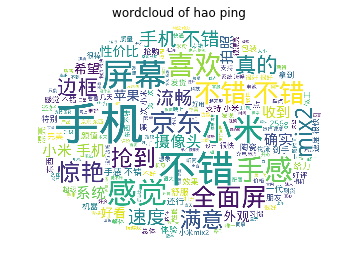

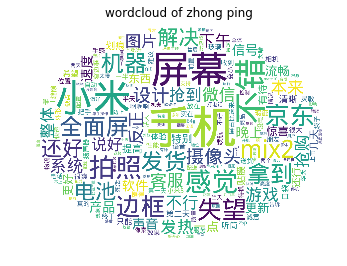

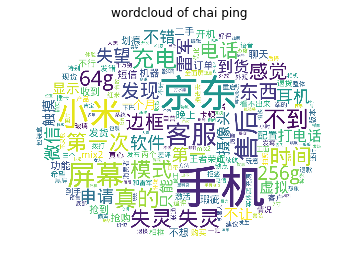

In [11]:
%matplotlib inline
warnings.filterwarnings("ignore")
for k in ['好评','中评','差评']:
    # textrank 关键词
    keywords=comments.get_keywords(comments.scores==k)
    print('{} 的关键词为：'.format(k)+'|'.join(keywords))
    # 主题分解
    comments.find_topic(comments.scores==k,n_topics=5);
    # 生成词云
    filename='wordcloud of {}'.format(k)
    comments.genwordcloud(comments.scores==k,filename=filename);
    print('='*20)

分析词云、关键词和主题容易发现

- 1、好评集中在：屏幕、惊讶、手感、全面屏、边框，大致就是讲小米手机不错；手感很好；全面屏很惊艳之类的；

- 2、中评集中在：屏幕、还好、失望、边框等

- 3、差评集中在：客服、失灵、售后、失望、模式、微信等，大致就是手机失灵；微信电话时的屏幕？因为版本等出现了一些售后客服问题？

只能说还凑合，模模糊糊、断断续续能理解一些。因为它只给出了词语，并没有配套的情感。


## 三、典型意见抽取、挖掘


电商评论不同于一般的网络文本，它主要的特点在于语料都是在针对产品的某些特征作出评价。这一节我们希望能通过算法找到这些特征。

细想下，语料主要在对特征做出评价，而特征一般是名词，评价一般是形容词。相对来讲产品的形容词不会很多，如“不错”、“流畅”、“很好”之类的，所以可以通过关联分析来发现初始的特征-形容词对，如("手机"-"不错")、("手机"-"流畅")等。

通过关联分析找打的特征-形容词对需要筛选，主要表现在两点。

1、里面不只名词-形容词对，两个名词，形容词-动词等都有可能；

2、没有考虑两个词语在文本之间的距离。比如名词是第一句话中的，形容词则是最后一句话中的；

筛选好后其实还不够，关联分析只会挖掘支持度大于一定数值的特征，我们称这种特征为 "**常见特征**"。那不常见特征怎么办？怎么才能挖出来？注意到上面已经挖掘出很多形容词啦，这些就是产品的最常用评价词语啦，我们可以通过它们反向挖掘出 "**不常见特征**"。


In [12]:
features=comments.get_product_features(min_support=0.005)
np.array(features).T

array(['质感', '屏幕', '体验', '总体', '256g', '机器', '京东', '边框', '性能', '质量', '摄像头',
       '陶瓷', '全面屏', '有点', '空间', '整体', '系统', '小米', '东西', '评价', '物流', '快递',
       '价格', '速度', '产品', '手感', '感觉', '颜值', '手机', '效果', '外观', '性价比', '想象'], 
      dtype='<U4')

可以看到与手机有关的大部分特征都找出来啦，另外有一些是关于京东的，如"速度"、"京东"、"快递"。还一些不是特征的，比如："有点","想象"

在语料中搜索与"外观"有关的语句，先看看大家在讲"外观"时，都在聊些啥？


In [16]:
texts_fw=comments.find_keywords('外观|质感')
texts_fw.head(15)

0          买这电话就是奔着外观
4                质感不错
5               手机在外观
6           质感壳就原汁原味了
18         买这电话就是奔着外观
20            mix2的外观
21         没有一个人没有被外观
40     质感有点lumia的正面感觉
76        还没有小米note外观
79       用了5天了手机不管是外观
90         机身边角更圆润在外观
149             内心和外观
201              机子外观
293            这款手机外观
359     质感也好 | 单单一个外观
Name: content, dtype: object

看来小米MIX2的外观还是很不错的，有很多人都是冲着外观买的。接下来我们来量化各个特征的好评占比和差评占比。

本来这里是想利用snownlp情感分析包来完成的，因为它能给出评价是否是正面的具体概率大小。考虑到情感分析目前的准确率，这里我们还是用原始的评分来量化。以刚刚的关键词 "外观|质感" 为例，我们有

In [17]:
comments.scores[texts_fw.index].value_counts()

好评    54
中评     1
Name: score, dtype: int64

利用这种方法，扩大到上述所有的特征可以得到：

In [13]:
features_new=list(set(features)-set(['有点','物流','想象','速度快'])|set(['拍照','照相','内存','续航','全面屏']))
features_opinion,feature_corpus=comments.features_sentiments(features_new,method='score')
print(features_opinion.sort_values('mention_count',ascending=False))

     total mention_count p_positive  p_negative
手机    3175           336   0.925595   0.0386905
小米    3175           329   0.963526   0.0121581
感觉    3175           174   0.965517   0.0114943
屏幕    3175           154   0.902597   0.0324675
速度    3175           148   0.972973  0.00675676
京东    3175           147   0.918367   0.0544218
手感    3175           124   0.991935  0.00806452
系统    3175            87   0.954023   0.0114943
边框    3175            83   0.927711   0.0240964
摄像头   3175            81   0.950617   0.0246914
效果    3175            63   0.984127           0
全面屏   3175            54   0.962963   0.0185185
拍照    3175            50       0.94        0.02
东西    3175            47   0.914894   0.0638298
体验    3175            47   0.957447   0.0212766
评价    3175            41          1           0
256g  3175            37   0.891892   0.0810811
外观    3175            36   0.972222           0
质量    3175            36          1           0
性价比   3175            34          1     

In [14]:
print(features_opinion[features_opinion['mention_count']>=30].sort_values('p_positive'))
print('\n好评占比大于所有样本(好评率96.54%)的特征：')
print(features_opinion[(features_opinion['mention_count']>=30)&(features_opinion['p_positive']>=0.9654)].index)
print('\n好评占比小于所有样本(好评率96.54%)的特征：')
print(features_opinion[(features_opinion['mention_count']>=30)&(features_opinion['p_positive']<0.9654)].index)

     total mention_count p_positive  p_negative
256g  3175            37   0.891892   0.0810811
屏幕    3175           154   0.902597   0.0324675
东西    3175            47   0.914894   0.0638298
京东    3175           147   0.918367   0.0544218
手机    3175           336   0.925595   0.0386905
边框    3175            83   0.927711   0.0240964
快递    3175            31   0.935484   0.0322581
拍照    3175            50       0.94        0.02
摄像头   3175            81   0.950617   0.0246914
系统    3175            87   0.954023   0.0114943
体验    3175            47   0.957447   0.0212766
全面屏   3175            54   0.962963   0.0185185
小米    3175           329   0.963526   0.0121581
感觉    3175           174   0.965517   0.0114943
外观    3175            36   0.972222           0
速度    3175           148   0.972973  0.00675676
效果    3175            63   0.984127           0
手感    3175           124   0.991935  0.00806452
质量    3175            36          1           0
性价比   3175            34          1     

可以看到提及最多的特征依次为：**感觉、屏幕、速度、手感、系统、边框、摄像头、全面屏、拍照、体验、256g、外观、质量、性价比**

其中比较好的依次为：**性价比、质量、手感、速度、外观、感觉**

其中稍差些的依次为：**256g、屏幕、边框、拍照、摄像头、系统、体验、全面屏**

最后的最后我们来看下这些特征对应的语料。

In [18]:
print('='*20+'256g'+'='*20)
print('//'.join(comments.find_keywords('256g').head(15)))
print('='*20+'屏幕'+'='*20)
print('//'.join(comments.find_keywords('屏幕').head(15)))
print('='*20+'边框'+'='*20)
print('//'.join(comments.find_keywords('边框').head(15)))
print('='*20+'拍照'+'='*20)
print('//'.join(comments.find_keywords('拍照').head(15)))
print('='*20+'摄像头'+'='*20)
print('//'.join(comments.find_keywords('摄像头').head(15)))
print('='*20+'系统'+'='*20)
print('//'.join(comments.find_keywords('系统').head(15)))
print('='*20+'体验'+'='*20)
print('//'.join(comments.find_keywords('体验').head(15)))
print('='*20+'全面屏'+'='*20)
print('//'.join(comments.find_keywords('全面屏').head(15)))

====================256g====================
我购买的是最高配256g产品//不过256g这个价格的手机也就这款了//运气好看到256g版的突然有货了//是256g的没错//内存有256g版本的//但是256g真心用不了//等了几天抢了256g的//结果只有256g的//去论坛看大家说256g的是现货结果当时去买总是提示抢不到//只好买256g的版本了//内存256g也很大//一看256g有货//买的256g的//终于买到了256g手机//顶配版居然没有256g的
====================屏幕====================
打开手机给我的感觉是屏幕边框比较小//缺点就是屏幕太脆弱//但是荣耀8屏幕有点小//应该是屏幕的问题//所以从屏幕正面看过去//圆角的屏幕从视觉上还需要适应一下 | 9的屏幕有些app在使用时会出问题//可以说mix2的屏幕跟小米6机身差不多大//但解决了一代用屏幕共振传音小的问题//再加个屏幕的大黑边 | 新mix2的屏幕就是泥巴屏//就是自拍需要翻转屏幕略显麻烦//就是屏幕比较长点稍微宽窄点之外没有任何特色 | 不过还好屏幕没有偏色发黄的感觉//夜景液晶屏幕显示较差//感觉屏幕小好多了//无非都是屏幕上下拉大//还好不过这屏幕6
====================边框====================
上边框的圈角有时看着像不对称样//打开手机给我的感觉是屏幕边框比较小//屏幕边缘和边框的边缘还是有不少距离的//一开始收到的时候看见确实边框大点//网上说的黑边框实际看起来还是可以接受 | 毕竟边框在摔落时能抵抗不少冲击//屏幕和边框之间有少许残胶//三边框宽 | mix2宣传照的边框你能p更细点吗//这外边框比宣传图大不止一点//的机身边框也采用弧度设计//其实连超窄边框都没有做到 | 屏幕外的玻璃离边框是挺近的//我觉得无边框不适合我 | 这个边框大一点反而不容易误触//就是屏幕大了边框窄了//不过边框控制的不是很理想//大屏幕无边框确实看起来很好看//mix2的边框比一代粗了
====================拍照====================
手机拍照效果比较上一代有大步的提升//的摄像头在下面拍照不方便//如果是讲究拍照的话 | 如果对拍

总结一下差评主要表现在：

No1. 256g版本发货问题

No2. 窄边框问题

No3. 拍照问题，MIX2的拍照效果有待提升

No4. 前置摄像头在下面不方便

No5. 系统，暂不明确是好是坏


再来看好评

In [20]:
print('='*20+'系统'+'='*20)
print('//'.join(comments.find_keywords('体验').head(40)))

====================系统====================
用户体验非常好//用户体验上速度不比6s差//同事朋友争着体验我的mix2//作为用户体验真的非常好//屏幕亮度自动调节使用体验太差了//整体体验好很多//舍弃了这么多该有的好的体验值得么//机子总体体验很好//各方面体验都很完美//使用体验还不错//前置摄像头在手机底部拍照体验不好//具体体验得十一回去再体验了//有个不好的使用体验我要吐嘈下//在体验中//全面屏体验永远好不了//手机先体验几天再来追评//买之前去小米之家体验了一下//待体验后再做详细评价//手感和各方面体验都不错//还是挑战客户体验的节奏//这次购物体验非常好//操作体验很大陆化支持原生微信双开//手机还在体验中//感谢京东让我首先体验到mix2//上手体验一个下午//但是系统的使用体验还是差一点 | 使用体验非常好 | 只是希望厂家能在系统的使用体验上再多投入一些//从没体验过这么流畅的安卓操作体验//不过确实体验不错//回去体验后追加评价//待朋友体验后看如何//自己体验体验真机就知道了//让着急的第一时间体验快感//晚点再晒单和体验感受//使用体验还行//本来想买一个好一点的手机体验一下//握持感比在米家体验机好很多很多//买之前特意去小米之家体验了一下//特地体验了几天才来评价//但是miui体验比三星的友好太多了//然后手机本身目前只体验了两天


In [21]:
print('='*20+'性价比'+'='*20)
print('//'.join(comments.find_keywords('性价比').head(15)))
print('='*20+'质量'+'='*20)
print('//'.join(comments.find_keywords('质量').head(15)))
print('='*20+'手感'+'='*20)
print('//'.join(comments.find_keywords('手感').head(15)))
print('='*20+'速度'+'='*20)
print('//'.join(comments.find_keywords('速度').head(15)))
print('='*20+'外观'+'='*20)
print('//'.join(comments.find_keywords('外观').head(15)))

====================性价比====================
小米性价比还是很高的//确实性价比还是高的//感觉性价比比较高//mix2性价比绝对不如米6//小米性价比还是高//的确性价比超高//小米手机性价比很高哦//而且跟水果机相比还是性价比不错的//绝对比水果性价比高//小米mix2这款性价比目前算高的了 | 小米mix2这款手机性价比做的很好了//论性价比无疑是小米6//物美价廉好东西性价比高//指纹识别后盖很漂亮老人机外观漂亮字体大分辨率高性价比高//这款性价比如何自己想//总之性价比还挺不错的
====================质量====================
通话质量也没问题//手机质量绝对没问题//很好下次还会购买物流很快质量很好//商品质量好//货还没有试不知道质量如何到时再评论吧//比一代通话质量好了很多//所以大家就当作是产品质量合格的意思来看就行了//通话质量相比1确实好了不少//缺点是摄像成像质量被华为前一代旗舰p9秒成渣//但愿质量不让我失望//因为做工和质量欠缺//中途因为质量问题换过一次//商品质量好//但是通话质量和照相提升太多//通话质量没试
====================手感====================
向手感妥协了//陶瓷手感就是不一样//陶瓷后盖不论手感还是视觉都非常好//屏幕和手感都还行//配的手机后盖手感很好//到手把玩手感不错//背面的手感真心好//拿在手里的手感很好//手机手感很好//原装手机壳手感很细腻//另外原配外壳手感也是一级棒//机子外观手感都挺不错的//陶瓷后背手感光滑//陶瓷手感很舒服//手机手感好了很多
====================速度====================
晚上照相速度太慢//运营速度很快//运行速度快//用户体验上速度不比6s差//晚上照相速度太慢//手机运行速度也很流畅 | 打开软件速度也很快//但是速度快//处理器835同821处理任务及反应速度误差很小//三是运行速度比预期的慢//物流速度闪电//手机速度快//软件的安装速度快 | 打开速度快 | 运行速度快//整体来说运行速度比1更快//这个物流速度太牛了 | 不过初步感觉指纹解锁速度没有华为好//送货速度快
===================

总结一下好主要表现在：

No1. 性价比高

No2. 质量不错，童话质量提升很多

No3. 陶瓷手感很好，外观很漂亮

No4. 运行速度还行
